# Sequence Models
Tutorial link: [Sequence Models and Long-Short Term Memory Networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)

Original author: Robert Guthrie.

In this tutorial, you will learn about LSTM neural networks and see an example of how they can be used to recognize parts of speech.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import jdc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Image

%matplotlib inline

torch.manual_seed(1)

## Introduction
### RNNs
* Difficulty learning widely separated relationships in long sequences.
### What is an LSTM?
* Long Short-Term Memory.
* Able to learn long term dependencies in a sequence.
* Uses a cell state and gates to remember relationships.
    
**Example:** _The humidity is very high. Today it is going to_ _**rain**_. A regular RNN might not do a good job predicting the word **rain**.

### Rolled Out LSTM Network

<img src="https://raw.githubusercontent.com/PythonWorkshop/intro-to-nlp-with-pytorch/master/images/lstm_flow.png" width=50%>

### LSTM Cell

<img src="https://raw.githubusercontent.com/PythonWorkshop/intro-to-nlp-with-pytorch/master/images/lstm_inner_workings.png" width=50%>

## Activation Functions
An LSTM uses two types of activation functions:
* Sigmoid activation function.
* Tanh activation function.

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-1*z))

In [3]:
ACTIVATIONS = {'sigmoid': sigmoid,
               'tanh': np.tanh}

In [4]:
def plot_activation(activation):
    if activation not in ACTIVATIONS:
        return None

    z = np.arange(-10, 11, 1)
    g = ACTIVATIONS[activation](z)
    
    plt.plot(g)
    plt.title(activation.title())
    plt.xlabel('x')
    plt.ylabel('{}(x)'.format(activation))
    plt.show()

### Sigmoid Activation Function
Pushes input value between 0 and 1.

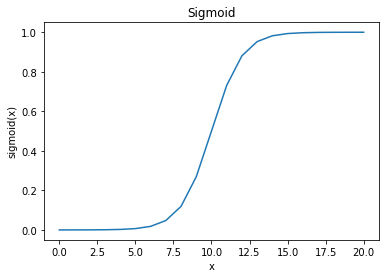

In [5]:
plot_activation('sigmoid')

### Tanh Activation Function
Pushes input values between -1 and 1.

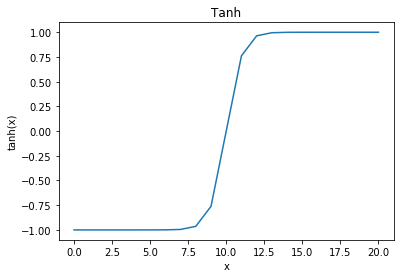

In [6]:
plot_activation('tanh')

### LSTM Components
An LSTM uses three gates:
* Forget Gate
* Input Gate
* Output Gate

#### Forget Gate
* Decide what information to remove from cell state.
* Sigmoid layer.

**Example Continued:** 
* Network receives as input low humidity.
* Network adjusts the rain likelihood for today to low. 
* The forget gate then removes the current state of rain likelihood.

<img src="../images/LSTM3-focus-f.png" width=80%>
<div class="row" style="font-size: 10px">
    <div class="col-md-12">
        <p><a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>, colah's blog, August 27, 2015
    </div>
</div>

#### Input Gate.
* Decide what information to store in cell state.
* Decide what to update.
    * Sigmoid layer. 
* Create candidate values for cell state.
    * Tanh layer.
    
**Example Continued:**
* replace the previous rain likelihood with the new likelihood for dry weather.

<img src="../images/LSTM3-focus-i.png" width=80%>
<div class="row" style="font-size: 10px">
    <div class="col-md-12">
        <p><a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>, colah's blog, August 27, 2015
    </div>
</div>

#### Update Cell State
* Remove forgotten information.
    * Multiply $f_t$ by old cell state.

* Add new candidate values scaled by their importance.
    * Add $i_t\ast\tilde{C}_t$

<img src="../images/LSTM3-focus-C.png" width=80%>
<div class="row" style="font-size: 10px">
    <div class="col-md-12">
        <p><a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>, colah's blog, August 27, 2015
    </div>
</div>

#### Output Gate
* Return filtered version of the cell state.

**Example Continued:**
* Keep track of humidity magnitude to help the network decide whether to predict a large storm or just light rain.

<img src="../images/LSTM3-focus-o.png" width=80%>
<div class="row" style="font-size: 10px">
    <div class="col-md-12">
        <p><a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>, colah's blog, August 27, 2015
    </div>
</div>

### Very Simple Example 1
* Create an LSTM in PyTorch using a **`for`** loop.

In [7]:
# Define LSTM architecture
SEQUENCE_LEN = 5  # The length of the sequence
INPUT_SIZE = 1  # Number of input features per time step
HIDDEN_SIZE = 1  # Number of LSTM blocks per layer of the RNN
BATCH_SIZE = 1  # The batch size
lstm = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)

# Create fake inputs for the LSTM
inputs = torch.randn(SEQUENCE_LEN, BATCH_SIZE, INPUT_SIZE)

# Initialize the hidden state and cell states.
hidden_0 = torch.randn(1, BATCH_SIZE, HIDDEN_SIZE)
cell_0 = torch.randn(1, BATCH_SIZE, HIDDEN_SIZE)

# Step through the LSTM as it takes in the input sequence
for i, in_value in enumerate(inputs):
    # Step through the sequence one element at a time.
    # After each time step, hidden contains the hidden state.
    out, hidden_out = lstm(in_value.view(1, 1, -1), (hidden_0, cell_0))
    print('x_{}: {}'.format(i+1, out))
    print('h_{}: {}'.format(i+1, hidden_out))
    print('')

x_1: tensor([[[0.1286]]], grad_fn=<StackBackward>)
h_1: (tensor([[[0.1286]]], grad_fn=<StackBackward>), tensor([[[0.5273]]], grad_fn=<StackBackward>))

x_2: tensor([[[0.1395]]], grad_fn=<StackBackward>)
h_2: (tensor([[[0.1395]]], grad_fn=<StackBackward>), tensor([[[0.4831]]], grad_fn=<StackBackward>))

x_3: tensor([[[0.1322]]], grad_fn=<StackBackward>)
h_3: (tensor([[[0.1322]]], grad_fn=<StackBackward>), tensor([[[0.5156]]], grad_fn=<StackBackward>))

x_4: tensor([[[0.1449]]], grad_fn=<StackBackward>)
h_4: (tensor([[[0.1449]]], grad_fn=<StackBackward>), tensor([[[0.4218]]], grad_fn=<StackBackward>))

x_5: tensor([[[0.1443]]], grad_fn=<StackBackward>)
h_5: (tensor([[[0.1443]]], grad_fn=<StackBackward>), tensor([[[0.4398]]], grad_fn=<StackBackward>))



Here, **`x`** is the output and **`h`** is the value of the hidden and cell states at each step in the sequence 

### Very Simple Example 2
* Create an LSTM in PyTorch using **`cat`**.

In [8]:
# Define LSTM architecture
SEQUENCE_LEN = 5  # The length of the sequence
INPUT_SIZE = 1  # Number of input features per time step
HIDDEN_SIZE = 1  # Number of LSTM blocks per layer of the RNN
BATCH_SIZE = 1  # The batch size
lstm = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)

# Create the inputs for the LSTM
inputs = [torch.randn(BATCH_SIZE, INPUT_SIZE) for _ in range(SEQUENCE_LEN)]

# Concatenate the inputs so that they are a tensor
inputs = torch.cat(inputs).view(len(inputs), 1, -1)

# Initialize the hidden state and cell states.
hidden_0 = torch.randn(1, BATCH_SIZE, HIDDEN_SIZE)
cell_0 = torch.randn(1, BATCH_SIZE, HIDDEN_SIZE)

out, hidden = lstm(inputs, (hidden_0, cell_0))  # out = all states, hidden = last state and last cell state

In [9]:
print('out: {}'.format(out))
print('last hidden and cell states: {}'.format(hidden))

out: tensor([[[-0.1616]],

        [[-0.1378]],

        [[ 0.0745]],

        [[-0.2183]],

        [[-0.2227]]], grad_fn=<StackBackward>)
last hidden and cell states: (tensor([[[-0.2227]]], grad_fn=<StackBackward>), tensor([[[-0.9171]]], grad_fn=<StackBackward>))


## Example: An LSTM for Part-of-Speech Tagging
* Predict parts-of-speach in a sentence.

### Prepare the data:
* Training data is a list of list pairs.
    * First list is a sentence.
    * Second list are the parts-of-speech tags for each word in the sentence.

In [10]:
training_data = [
    ("The dog ate the apple.".split(), ["Determiner", "Noun", "Verb", "Determiner", "Noun"]),
    ("Everybody read that book.".split(), ["Noun", "Verb", "Determiner", "Noun"])
]
training_sentences = [training_data[x][0] for x in range(len(training_data))]

#### Clean the data
Make all words lower case and remove punctuation.

In [11]:
training_data_clean = []
for sentence, tags in training_data:
    clean_sentence = [x.lower().split('.')[0] for x in sentence]
    training_data_clean += [(clean_sentence, tags)]
training_sentences_clean = [training_data_clean[x][0] for x in range(len(training_data_clean))]

#### Create vocabulary
Using all words in each sentence of the training data, create a vocabulary.

In [12]:
words = []
for sentence in training_sentences_clean:
    words += sentence
vocab = list(set(words))
print(vocab)

['dog', 'read', 'everybody', 'the', 'apple', 'ate', 'book', 'that']


#### Create mapping dictionaries
Using dictionaries to convert words to integers.

In [13]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
print('word_to_ix: {}'.format(word_to_ix))

word_to_ix: {'the': 3, 'apple': 4, 'ate': 5, 'dog': 0, 'read': 1, 'book': 6, 'everybody': 2, 'that': 7}


Map the parts-of-speech tags to integers:

In [14]:
# Tags to integers
tag_to_ix = {"Determiner": 0, "Noun": 1, "Verb": 2}

Map the integers back to parts-of-speech.

In [15]:
# Integers to tags
ix_to_tag = {0: "Determiner", 1: "Noun", 2: "Verb"}

### Set Hyperparameters

In [16]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
LEARNING_RATE = 0.1
NUM_EPOCHS = 300

### Create the model
* **`LSTMTagger`** class.
    * Inherits **`nn.Module`** from PyTorch.
    * Inputs:
        * Embedding dimension.
        * Number of hidden dimensions.
        * Vocabulary size.
        * Tag set size.

In [17]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM: Inputs are embeddings, outputs are hidden states
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # Linear layer maps hidden space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

Create a function to initialize the hidden states.

In [18]:
%%add_to LSTMTagger
def init_hidden(self):
    """
    Initialize the hidden state. The axes correspond to (num_layers, minibatch_size, hidden_dim).
    """
    return (torch.zeros(1, 1, self.hidden_dim),
            torch.zeros(1, 1, self.hidden_dim))

Define a function to make a forward pass through the recurrent LSTM network. It will return the predict tag values given an input sentence.

In [19]:
%%add_to LSTMTagger
def forward(self, sentence):
    """
    Make a forward pass through the LSTM.
    
    :param sentence: The input sentence.
    :type sentence: list
    :return: A Tensor of tag scores.
    :rtype: Tensor
    """
    embeds = self.word_embeddings(sentence)
    lstm_out, self.hidden = self.lstm(
        embeds.view(len(sentence), 1, -1), self.hidden)
    tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

### Helper Function
Map either words or tags to integers, using the previously defined dictionaries (**`tag_to_ix`**, **`ix_to_tag`**).

In [20]:
def prepare_sequence(seq, to_ix):
    """
    Convert words or tags to intigers and return a Pytorch tensor.
    :param seq: Sequence of words.
    :type seq: list
    :param to_ix: Dictionary mapping words or tags to intigers.
    :return: A Pytorch tensor of indices.
    :rtype: Tensor
    """
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

### Train the model:

Create the LSTM Pytorch model using the hyperparameters defined above.

In [21]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

Define the loss function. In this case, we will be using a negative log likelihood function, which is useful in classification problems.

In [22]:
loss_function = nn.NLLLoss()

#### Negative Log Likelihood
We can illustrate negative log likelihood in the following diagram:

<img src="https://raw.githubusercontent.com/PythonWorkshop/intro-to-nlp-with-pytorch/master/images/nll_loss.png" width=50%>

We will train the model using stochastic gradient descent.

In [23]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Let's run the model before any training has been done and store the scores to a **`list`**. We will then compare these scores with the scores after training.

In [24]:
store_initial_probabilities = []
store_initial_predictions = []
with torch.no_grad():
    for sentence in training_sentences_clean:
        inputs = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)
        tag_probabilities = tag_scores.exp()
        max_values, max_indices = torch.max(tag_probabilities, 1)
        initial_prediction = [ix_to_tag[x] for x in max_indices.numpy()]
        store_initial_predictions.append(initial_prediction)
        store_initial_probabilities.append(tag_probabilities)

Now, we will train the model.

In [25]:
for epoch in range(NUM_EPOCHS):
    for sentence, tags in training_data_clean:
        # Set gradients equal to zero after each intance
        model.zero_grad()
        
        # Initialize hidden state of LSTM after each intance
        model.hidden = model.init_hidden()
        
        # Turn inputs into tensors of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        # Run forward pass
        tag_scores = model(sentence_in)
        
        # Compute the loss, gradients, and update the parameters
        loss = loss_function(tag_scores, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Update model parameters
        optimizer.step()

Our model has now finished training. Let's print out some statistics to show how well the model training performed.

In [26]:
# Print out the scores after training the model
store_initial_probabilities.reverse()
store_initial_predictions.reverse()
with torch.no_grad():
    for sentence in training_sentences_clean:
        inputs = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)
        tag_probabilities = tag_scores.exp()
        max_values, max_indices = torch.max(tag_probabilities, 1)
        predictions = [ix_to_tag[x] for x in max_indices.numpy()]
        
        print('Before training:')
        print(' - initial probabilities: {}'.format(store_initial_probabilities.pop()))
        print(' - sentence: {}'.format(' '.join(sentence)))
        print(' - predicition: {}'.format(store_initial_predictions.pop()))
        print('After training:')
        print(' - final probabilities: {}'.format(tag_probabilities))
        print(' - sentence: {}'.format(' '.join(sentence)))
        print(' - prediction: {}'.format(predictions))
        print('')

Before training:
 - initial probabilities: tensor([[0.3524, 0.3432, 0.3045],
        [0.3714, 0.3318, 0.2967],
        [0.3697, 0.3445, 0.2858],
        [0.3423, 0.3512, 0.3065],
        [0.3389, 0.3572, 0.3039]])
 - sentence: the dog ate the apple
 - predicition: ['Determiner', 'Determiner', 'Determiner', 'Noun', 'Noun']
After training:
 - final probabilities: tensor([[0.9714, 0.0151, 0.0135],
        [0.0319, 0.9592, 0.0089],
        [0.0232, 0.0215, 0.9553],
        [0.9630, 0.0170, 0.0200],
        [0.0099, 0.9854, 0.0047]])
 - sentence: the dog ate the apple
 - prediction: ['Determiner', 'Noun', 'Verb', 'Determiner', 'Noun']

Before training:
 - initial probabilities: tensor([[0.3556, 0.3848, 0.2596],
        [0.3501, 0.3671, 0.2828],
        [0.3864, 0.3271, 0.2865],
        [0.3473, 0.3518, 0.3010]])
 - sentence: everybody read that book
 - predicition: ['Noun', 'Noun', 'Determiner', 'Noun']
After training:
 - final probabilities: tensor([[0.0038, 0.9919, 0.0043],
        [0.054

### What do the scores mean?
* The scores are used to predict the parts-of-speech for each word in a sentence. 
* A corresponding list of of possible parts-of-speech is assigned to each word. 
* This list is the same for all data passed through the model. 

For example:

In [27]:
print('Let us take the sentence: {}'.format(' '.join(training_sentences[0])))
print('For the word "{}" the list of possible parts-of-speech are: {}'.format(training_sentences[0][0], [x for x in ix_to_tag.values()]))

Let us take the sentence: The dog ate the apple.
For the word "The" the list of possible parts-of-speech are: ['Determiner', 'Noun', 'Verb']


* A score is given to each part-of-speech in the list.
* The prediction is the part-of-speech with the highest score.
* Correct prediction = `Determiner` and will have highest score.

## Save Model
Save the Pytorch model to disk. This model will be used in the deployment tutorial.

In [28]:
models_path = os.path.join(os.getcwd(), 'models', 'model.pt')

In [29]:
torch.save(model.state_dict(), models_path)

## Load Model

In [30]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))

In [31]:
model.load_state_dict(torch.load(models_path))

In [32]:
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(8, 6)
  (lstm): LSTM(6, 6)
  (hidden2tag): Linear(in_features=6, out_features=3, bias=True)
)

Run a training example through the loaded model and make a prediction.

In [33]:
inputs = prepare_sequence(training_sentences_clean[0], word_to_ix)
tag_scores = model(inputs)
tag_probabilities = tag_scores.exp()
max_values, max_indices = torch.max(tag_probabilities, 1)
predictions = [ix_to_tag[x] for x in max_indices.numpy()]
print('sentence: {}'.format(' '.join(training_sentences[0])))
print('parts-of-speach: {}'.format(predictions))

sentence: The dog ate the apple.
parts-of-speach: ['Determiner', 'Noun', 'Verb', 'Determiner', 'Noun']


### References:

1. [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)